<div>
    <center>
        <h1>
            <font color="#902e59">CQF June 2023 Intake: Final Project</font>
        </h1>
    </center>
    <center>
        <h3>Deep Learning for Asset Prediction</h3>
    </center>
    <center>
        <h5>Will Colgate, Singapore, January 2024</h5>
    </center>
    <center>
        <a href='https://github.com/will-j-c/cqf_final_project_DL'>
            <svg height="32" aria-hidden="true" viewBox="0 0 16 16" width="32">
            <path d="M8 0c4.42 0 8 3.58 8 8a8.013 8.013 0 0 1-5.45 7.59c-.4.08-.55-.17-.55-.38 0-.27.01-1.13.01-2.2 0-.75-.25-1.23-.54-1.48 1.78-.2 3.65-.88 3.65-3.95 0-.88-.31-1.59-.82-2.15.08-.2.36-1.02-.08-2.12 0 0-.67-.22-2.2.82-.64-.18-1.32-.27-2-.27-.68 0-1.36.09-2 .27-1.53-1.03-2.2-.82-2.2-.82-.44 1.1-.16 1.92-.08 2.12-.51.56-.82 1.28-.82 2.15 0 3.06 1.86 3.75 3.64 3.95-.23.2-.44.55-.51 1.07-.46.21-1.61.55-2.33-.66-.15-.24-.6-.83-1.23-.82-.67.01-.27.38.01.53.34.19.73.9.82 1.13.16.45.68 1.31 2.69.94 0 .67.01 1.3.01 1.49 0 .21-.15.45-.55.38A7.995 7.995 0 0 1 0 8c0-4.42 3.58-8 8-8Z"></path>
        </a>
    </center>
</svg>
</div>


### Introduction

Using machine and deep learning techniques to predict price movements is considered the holy grail of modern finance, with great focus from both individual professionals and hobbyists, to large multi national businesses with mixed results. Given the stochastic nature of markets, it is arguable if a reliable algorithm can be found that is actually effective in the "wild".

Operational complexities such as timely access to information, the brokerage spread and transaction costs make the task difficult before even considering the more philosophical question on how perfect the markets are. This is ratcheted up a notch with the irrational movements of crypto markets, which arguably have no underlying inherent value. 

Applying deep learning to these markets, whilst offering an interesting academic problem to explore, are unlikely to offer additional insight and the below should not be used as a basis for any investment decisions.

### A Note on the Project Workflow

The approach to this problem will follow the well trodden machine learning workflow as follows:

- Problem statements
- Data collection
- Exploratory data analysis
- Data cleaning
- Feature scaling and selection
- Model design and hypertuning
- Model evaluation

Given the subject matter is financial timeseries forecasting, the report will also include backtesting of the predictions versus a long only hold strategy, to understand if it achieves its objective.

A full process diagram is included in Appendix 1.

### Problem Statement

The objective is to produce a model that can predict positive moves using Long Short-Term Memory (LSTM) networks in short term financial time series.

I have chosen Ethereum (ETH) as the ticker to analyse (technically a pair with USD). Crypto markets are notoriously volatile and it seems like a decent challenge to try and tease some insight out of the mess.

For this purpose, I will aim to predict an hourly positive return. Defining a positive return is discussed in more detail as part of the labels section. This will be a binary classification problem with 1 being the label for a positive move and 0 otherwise.

Whilst accuracy of the predictions will be an important metric, precision and recall will arguably be more important as measures of success. The precision of calculating the upward moves in particular would be important as there is a realised financial loss from buying and selling at a loss in a high frequency setting. A thorough discussion of metrics is considered in the following pages. 

In [1]:
# Disable logs in notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Import configurations
from src.config import *
import tensorflow as tf

# Clear any backend
tf.keras.backend.clear_session()

# Set seeds for reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

### Data Collection

##### Raw Data

Access to data is one of the biggest problems for deep learning problems. The amount of data required to train a (good) deep learning neural network is usually much more than is available outside of a professional setting. High frequency intraday data especially is difficult to come by, presumably due to the differences in exchanges, the cost of storage and how valuable the data can be.

After exploring Yahoo Finance (via the `yfinance` python package) and the Alpha Vantage API, it became apparent that these sources did not have the amount of data required or reliable data.

In the end, the data was sourced from [https://www.cryptodatadownload.com/data/]() from the data available from the Gemini exchange.

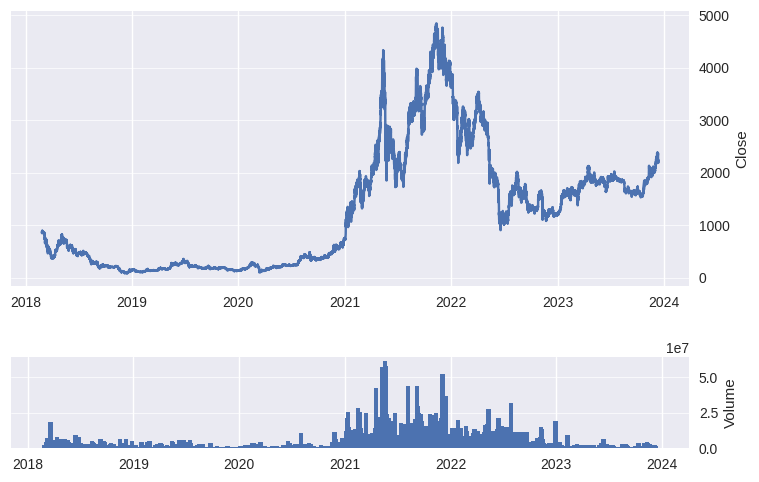

In [2]:
# Plotting closing price and volume
df = pd.read_csv('data/unscaled_clean_data.csv', parse_dates=True, index_col='unix')
plot_price_vol(df, 'close', 'volume')

The data appears to be relatively complete on an arbitrary inspection and shows the meteoric rise of the crypto markets generally in 2021 and 2022 followed by the collapse in price due to the FTX and LUNA scandals. The raw data goes back to 2016, but us truncated above in the above chart for the reasons explained in the next few paragraphs. 

The crypto market is notoriously emotion driven. Even glancing at social media or news outlets allows a person to gain a sense of how this is true. It follows then that some kind of sentiment regarding this emotional investing would potentially give some interesting insight into the problem statement. There is an interesting resource updated daily on [alternative.me](https://alternative.me/crypto/fear-and-greed-index/) called the fear and greed index. 

The index takes a weighted approach to a number of factors across 5 (formally, 6) data sources. A numerical value is assigned which falls into categories of:

- Extreme Fear
- Fear
- Neutral
- Greed
- Extreme Greed

The index is updated daily at 00:00 UTC.

In [3]:
# Load fear and greed data
df_fear_greed = pd.read_csv('data/raw/crypto_greed_fear_index.csv', parse_dates=True, index_col='timestamp')
# Drop unneeded columns
df_fear_greed.drop(['time_until_update', 'timestamp.1'], axis=1, inplace=True)
# Rename columns
df_fear_greed.columns = ['fg_value', 'fg_value_classification']
# Put classification to lower case
df_fear_greed['fg_value_classification'] = df_fear_greed['fg_value_classification'].str.lower()
df_fear_greed.head()

,fg_value,fg_value_classification
timestamp,,
2023-12-23 00:00:00+00:00,70,greed
2023-12-22 00:00:00+00:00,74,greed
2023-12-21 00:00:00+00:00,70,greed
2023-12-20 00:00:00+00:00,74,greed
2023-12-19 00:00:00+00:00,73,greed


The index could be a good indicator of sentiment in the crypto market as a whole. Crypto tokens do not have fundamental data so a traditional fundamental analysis cannot be undertaken. However, there are metrics associated with blockchains that can be accessed (such as transactions per second, blocks mined etc) that could be worth exploring in a further analysis but are outside the scope of this paper. 

The index only began on 1 February 2018 so all price data before this date has been dropped and the the daily metric forward filled to the hourly data. This would reflect that the index would apply to the price movements throughout the day. 

##### Feature Engineering

Feature engineering is the catch all term for using domain knowledge to generate insights from the raw dataset. Common data transformations for financial times series are known as technical analysis with associated literature that spans many volumes.

Using `pandas-ta`, I have generated standard technical indicators for the data based on high, low, open, close and volume. I have also generated temporal data to investigate if there is any kind of seasonality to returns. I have used the `scikit-learn` OneHotEncoder to encode these values (and the FG classification) into binary variables.

Interestingly, the `pandas-ta` module implements TA-Lib and candlestick patterns. Reading candlesticks is a classical version of technical analysis, originating from the rice markets of Japan. Recognising what patterns lead to an upward tick will be interesting to see.

##### Labelling the Data

Given the problem statement is to predict an hourly positive return. The 1 period return is calculated as follows:

$$
r_t = ln(\frac{p_t}{p_{t-1}})
$$

A practical approach to predicting a positive return for these purposes would be any net return (i.e. after transaction costs).

[Here](https://www.gemini.com/fees/api-fee-schedule) are the fees from the Gemini exchange for reference. The taker fee at the lowest volume per month is 0.4%. To account for interest on margin, I will round this up to 0.5% as an estimate.

Therefore, a label of 1 will mean that that the upward return in the next hour will be greater than 0.05% and 0 otherwise. Mathematically:

$$ y_t =
  \begin{cases}
    1      & \quad \text{if  } r_{t+1} > 0.005\\
    0  & \quad \text{otherwise}
  \end{cases}
$$

### Exploratory Data Analysis

EDA is an important step in 

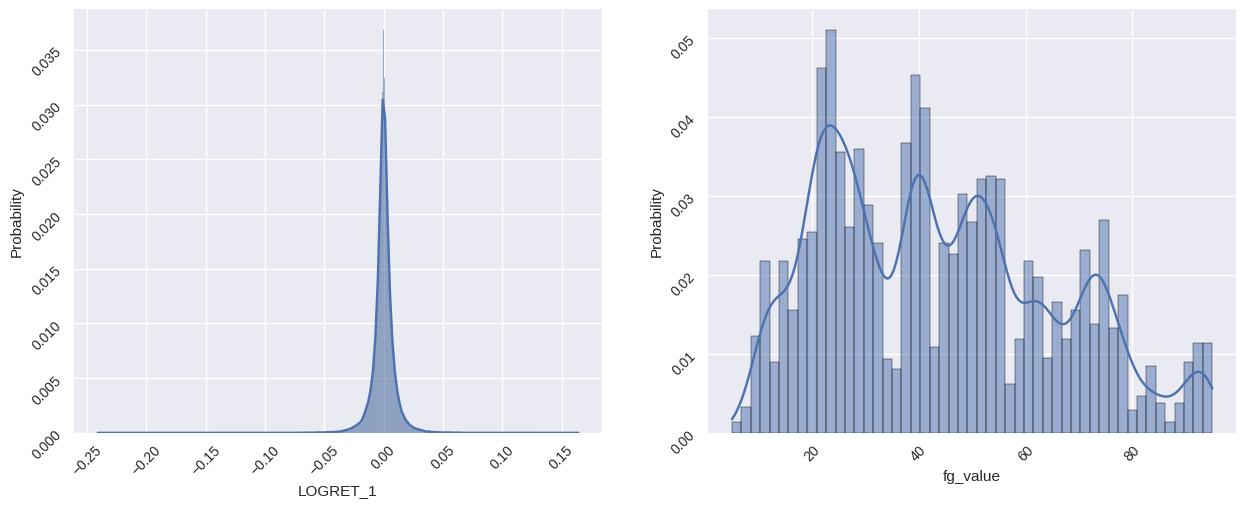

In [4]:
# Plot 
fig, axes = plt.subplots(1, 2)
sns.histplot(df, x='LOGRET_1', kde=True, ax=axes[0], stat='probability')
sns.histplot(df, x='fg_value', kde=True, ax=axes[1], stat='probability')
for ax in axes:
    ax.tick_params(labelrotation=45)
fig.set_figwidth(15)
plt.show()

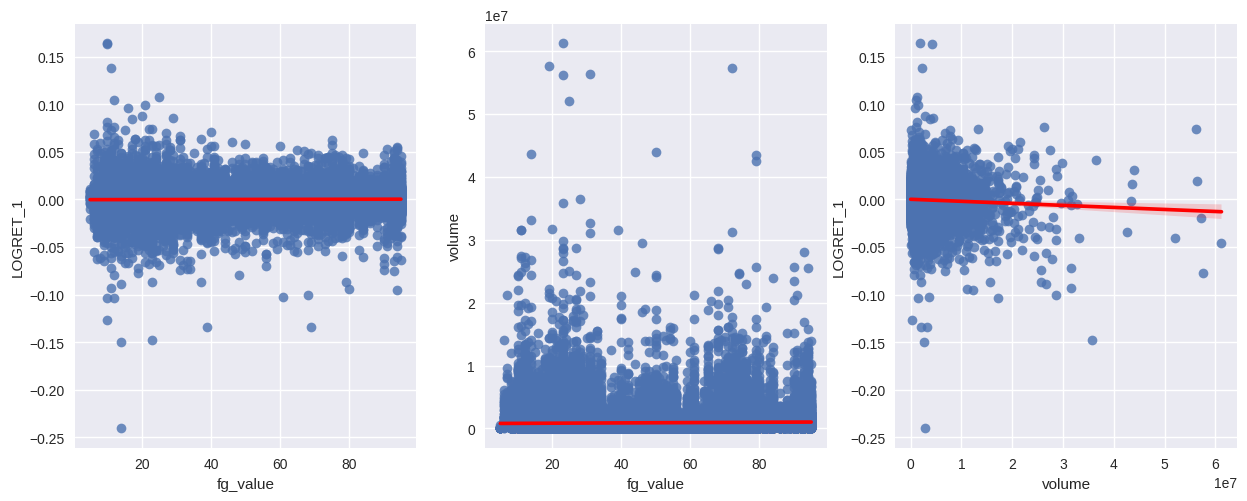

In [5]:
fig, axes = plt.subplots(1, 3)
sns.regplot(data=df, x='fg_value', y='LOGRET_1', ax=axes[0], line_kws=dict(color='r'))
sns.regplot(data=df, x='fg_value', y='volume', ax=axes[1], line_kws=dict(color='r'))
sns.regplot(data=df, x='volume', y='LOGRET_1', ax=axes[2], line_kws=dict(color='r'))
fig.set_figwidth(15)
plt.show()

Some observations from the above data:

- Return does not seem to be correlated with fg_value. However, higher fg_values (i.e. more greed in the index), seems to see the variance decrease (heteroscedasticity).
- There appears to be a slight negative correlation with fg_value and volume, indicating that less volume is traded during times of greed in the index. 
- Return does not have significatn outliers but volume does look like it would be a candidate for robust scaler.

In [6]:
# Checking for class imbalances
df['label'].value_counts()

label
0    40858
1     9809
Name: count, dtype: int64

The above does indicate that there is quite a severe class imbalance in the data that will need to be addressed at the model building stage otherwise the model will likely underperform due to bias.

Next, I have examined the correlation between features. Collinearity between features is present and there are a number of features that will need cleaning before they can be used in the model. 

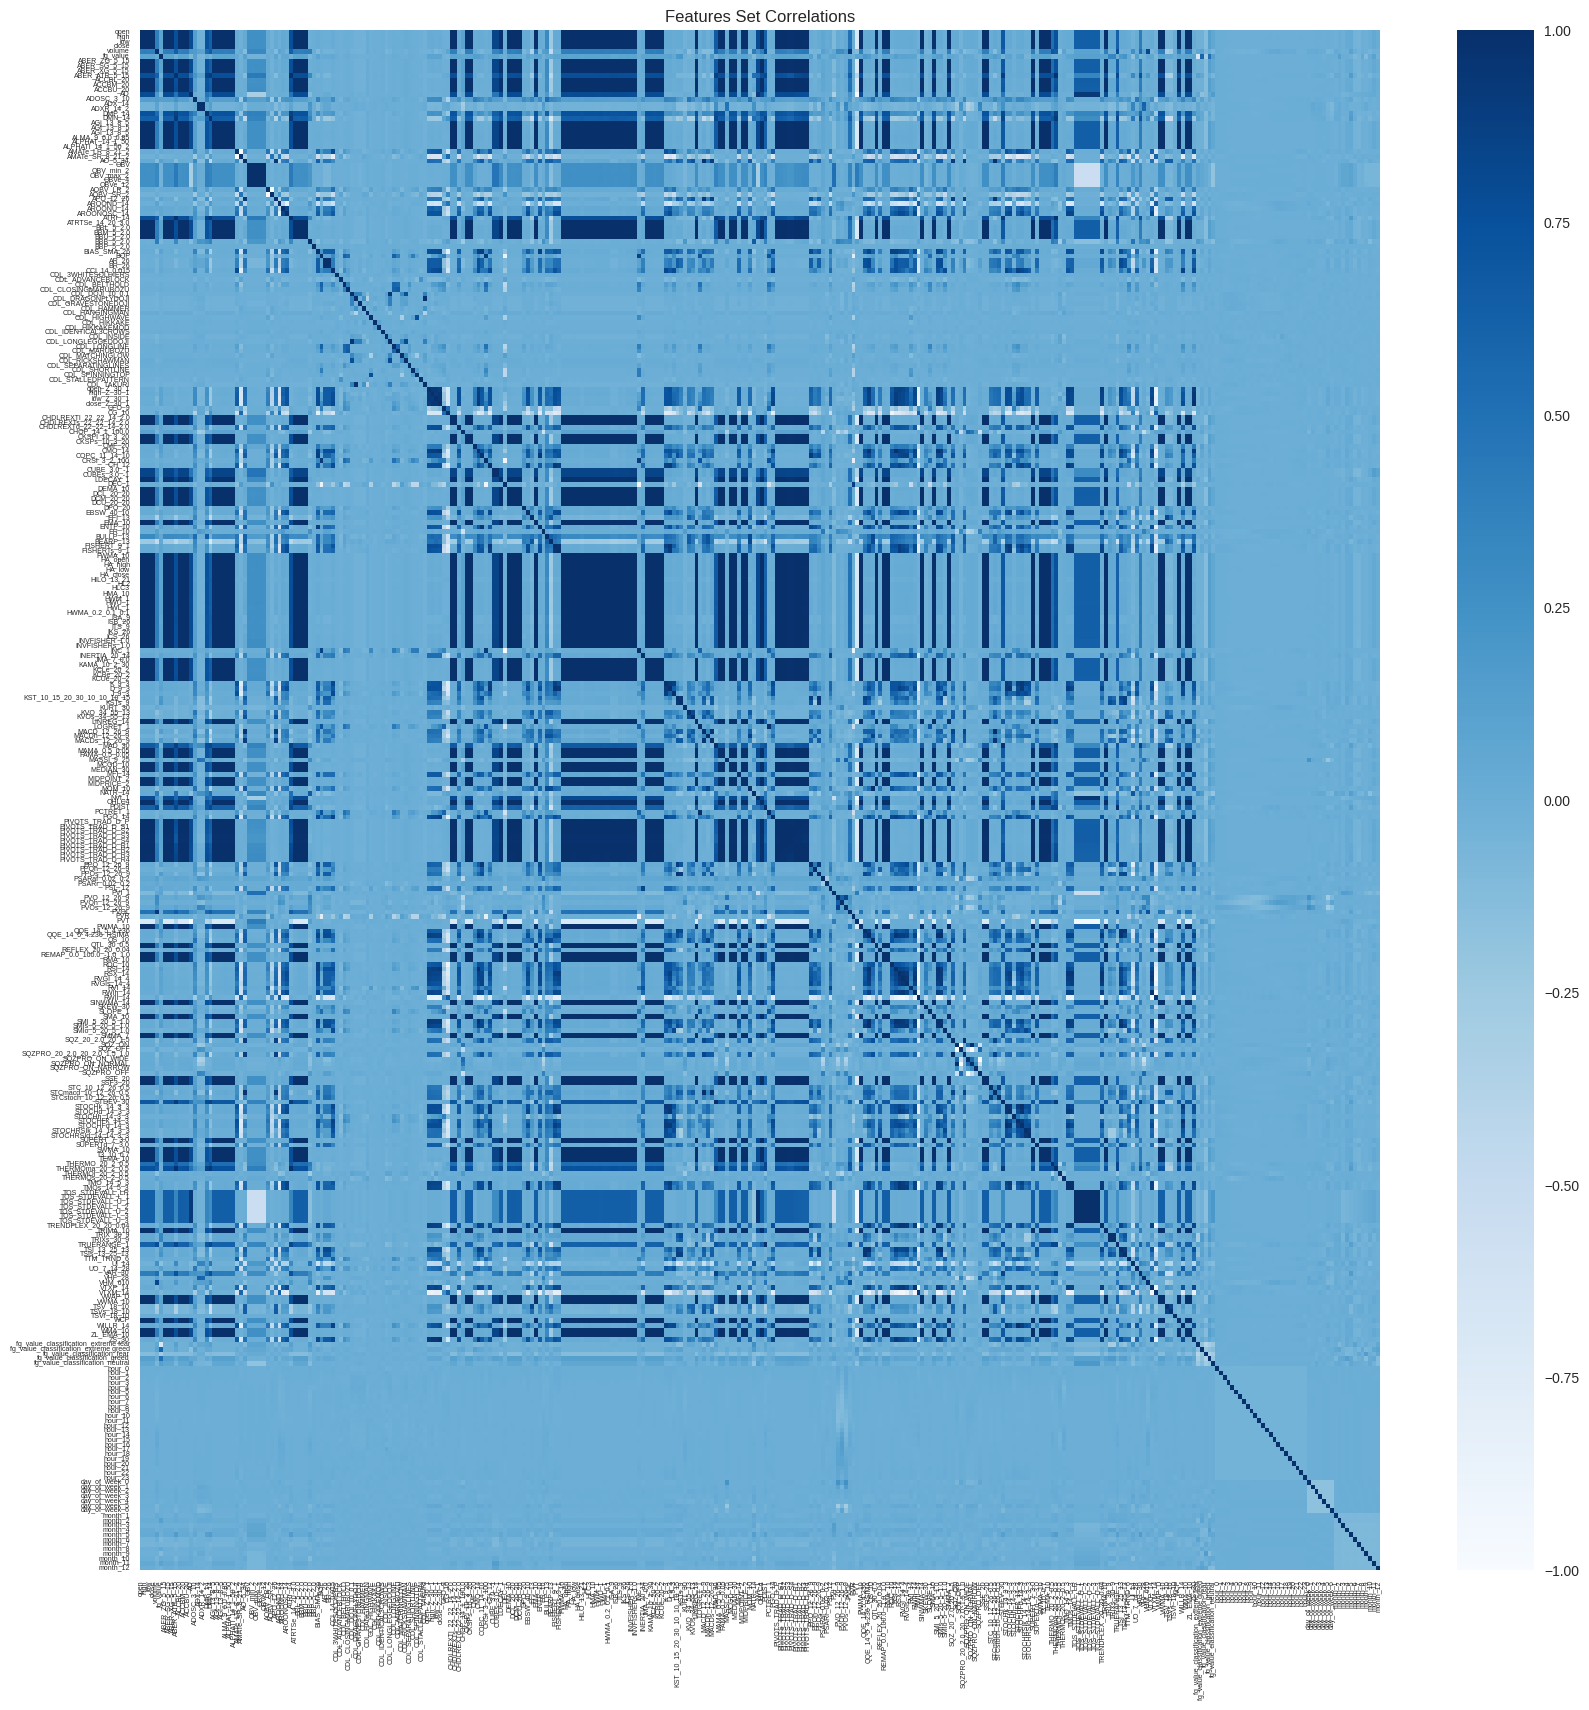

In [7]:
# Create a heatmap in Seaborn to see the features that are highly correlated and seek to remove them
X_cov = df.drop('label', axis=1).corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(X_cov, cbar=True, xticklabels=True, yticklabels=True, cmap='Blues')
plt.tick_params(labelsize=5)
plt.title('Features Set Correlations')
plt.show()

The heatmap of cleaned features shows clear collinearity between a number of features. Collinearity in ML problems affects performance and interpretability and so is generally best removed. There are multiple methods of doing this but in this paper, I have focused on the following two methods:

- Only retaining the first variable in a highly correlated pair
- Discarding variables with a variance inflation factor of greater than 5

The first method is self explanatory, the second is defined as:

$$
VIF_i = \frac{1}{1-R^{2}_{i}}
$$

Where $R^{2}_{i}$ is the unadjusted coefficient of determination for regressing variable $i$on all the remaining independent variables. A VIF equal to 1 indicates that the variables are not correlated, between 1 and 5, that there is moderate correlation between that variable and others and greater than 5 indicating high correlation with other variables. 

### Data Cleaning

As already alluded to in the proceeding sectons, the joining of the two raw data sources and computation of the technical indicators requires some cleaning. A number of steps have been taken to deal with this in the `clean_scale.py` script. These are:

- Drop all columns where `pandas.ta` has calculated NaN.
- Drop columns where 20,000 datapoints (out of 65k+) are missing.
- Remove the leading NaN rows of data due to calculation of rolling amounts (simples moving averages etc.).
- Removal of all columns with no variance, indicating a single value. This is because no variance in the data indicates no informative information for the algorithm. 

After this process, there are 324 features remaining in the dataset with hourly data from 26/02/2018 until 11/12/2023.

### Feature Scaling

In order to get the best results from deep learning models, data generally needs to be scaled to aid in faster calculation of cost functions during gradient descent. There are various scaling techniques commonly used but this model concentrates on two.

##### Min Max Scaler

The min max scaler rescales all features to within a range based on the following calculation:

$$
x_{scaled} = \frac{x_i - min(x)}{max(x) - min(x)}
$$

This scaler is relatively sensitive to outliers.

##### Robust Scaler

The Robust Scaler scales variables with significant outliers by using the quartiles of X to scale the variables. 

$$
x_{scaled} = \frac{x_i - Q_{1}(x)}{Q_{3}(x) - Q_{1}(x)} = \frac{x_i - Q_{1}(x)}{IQR(x)}
$$

A significant outlier is calculated for the purposes of this paper as one that is 10 times the IQR. Appendix 2 lists each feature remianing after cleaning the data and the scaler applied to each.

##### Split Data into Train and Test

Before applying the chosen sclaing methods to each column, the data needs to be split into train and test data. This is because the scaling algorithm will be fit to the training data only and the test data scaled using metrics calculated on the training data only. This technique helps to avoid data leakage of the test data into the training dataset and also helps with regularization. Note that as this is time series data, the data should not be shuffled.

Once the train and test data are split, the train data is split again into a train and validation set test the mdoel during the training process. 

All sets are then scaled using $x$ values calculated from the training set only to avoid any data leakage. 

### Feature Selection

There are many (and varied) techniques to feature selection and feature engineering as a whole, necessitating experimentation to try and meet the main objective of an efficient model with good predictive powers.

To attempt to achieve this, I have split the problem into four stages stages:

1. Removal of collinearity using one of the two techniques described above.
2. Use of boruta as a feature selection algorithm.
3. Dimension reduction using Uniform Manifold Approximation & Projection (UMAP), a relatively new and novel unsipervised learning algorith.
4. Input the results of the above pipeline (or part there of) into a baseline one layer LSTM model using `keras` and anlyse the results.

##### Boruta

The Boruta algorithm is designed around a random forest classifier. It seeks to establish what features contribute to the overall model. It does this by duplicating and shuffling the dataset into "shadow features". The classifier (in this case, a random forest) is then trained on both sets of data. Feature importance is compared to the shadow features. If the feature has a greater importance than its shadow equivalent, then the feature is retained.

The algorithm is implemented in Python through the `boruta_py` package. in order to capture as much data as possible, the parameter "perc" was set at 90 in line with the documentation so as to avoid too "strict" of an interpretaion of importance.

##### UMAP

Per the documentation, UMAP is a dimension reduction technique that can be used for visualisation similarly to t-distributed Stochastic Neighbor Embedding (t-SNE), but also for general non-linear dimension reduction. The mathamatics can be found in *McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*. According to the literature, UMAP offers significant performance improvements over other dimensionality techniques such as t-SNE and SOM. PCA was discounted in this analysis as it does not tend to work well on non-linear data.

The python implementation of UMAP takes a number of parameters but there are two main parameters that impact the clustering of the algoithm on the 2D plane.

| Hyperparameter | Description                                                                                                                                                                                                                                                                                                                                                                                | Value         |
|----------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|
| n_neighbors    | This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. Lower values of n_neighbours force the algorithm to focus more on the local structure, potentailly losing some of the global structure and vice versa. | 10            |
| min_dist       | This parameter controls how tightly UMAP is allowed to pack points together is the 2D representation. A lower min_dist generally means that points will clump together more. The choice of min_dist will depend on the use case of the algorithm, with a lower value generally being more useful for clustering problems.                                                                  | 0.1 (default) |

Appendix 3 explores the output of the algorithm on changing the above parameters and demonstrates why the above were chosen as a middle ground on local and global structure to use for dimension reduction of the dataset.

##### Baseline Model

In order to evaluate the various pipelines to understand the best set of features for this particular problem statement, a baseline deep learning model was used. This consisted on a single layer with 36 units and 'relu' activation, being:

$$ x^+ =
  \begin{cases}
    x      & \quad \text{if  } x > 0\\
    0  & \quad \text{otherwise}
  \end{cases}
$$

The past 6 hours (i.e. current and preceeding 5) of data was used a sequence length on the basis that this seemed like a reasonable amount of time to use in predicting an up movement in 1 hour's time but also, it is a good middle point in terms of performance. The model structure is detailed in the below diargram.

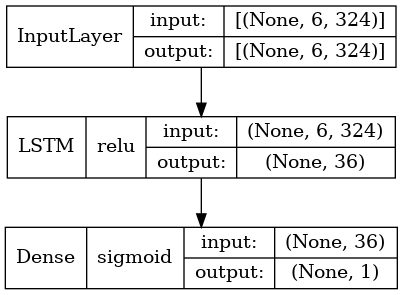

In [9]:
# Collect model files paths
baseline_model_fp = glob.glob('./models/*.keras')[0]
# Load the model
baseline_model = tf.keras.saving.load_model(baseline_model_fp)
# Plot the model details
tf.keras.utils.plot_model(baseline_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, to_file='./static/baseline.png')

The model input is a 3 dimentsional tensor in the form (batch, sequence length, features). The output of the dense layer is a $p$ prediction that the output will be 1 such that:

$$ \text{prediction} =
  \begin{cases}
    1      & \quad \text{if  } p > 0.5\\
    0  & \quad \text{otherwise}
  \end{cases}
$$

The optimizer used is Adam (see *Kingma et al. 2014*) and the loss function is binary cross entropy, being the most appropriate loss function for evaluating binary classification problems.

Before training, the class imbalance was dealt with by assigning a weight to each class. The weights are calculated by taking 1 divided by the count of the class multiplied by the total length of the array divided by 2.

An early stopping callback was used in the model monitoring the validation loss (i.e. the model will cease running 10 epochs after the validation loss has ceased decreasing).

##### Experiment Results

In [10]:
present_tensorboard_logs()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


,max_binary_accuracy,max_binary_accuracy_epoch,max_precision,max_precision_epoch,max_recall,max_recall_epoch,max_f1,max_f1_epoch
run_name,,,,,,,,
run_pairwisecorr__boruta_01-14-2024-14:16:04,0.698578,13,0.392012,13,0.885132,3,0.484584,17
run_boruta_01-14-2024-14:40:32,0.581991,4,0.329438,4,0.906438,1,0.468319,4
run_vif_01-14-2024-14:23:39,0.641601,28,0.342770,28,0.928208,0,0.466315,16
run_vif__boruta_01-14-2024-14:31:03,0.583992,34,0.324927,34,0.858268,4,0.457744,2
run_vif__umap_01-14-2024-14:50:45,0.656767,11,0.345592,11,0.781843,0,0.435312,9
run_pairwisecorr_01-14-2024-14:15:30,0.562085,0,0.274124,0,0.930523,9,0.403786,16
run_all_01-14-2024-14:14:58,0.706477,2,0.353408,2,0.963872,5,0.400226,18
run_boruta__umap_01-14-2024-14:45:33,0.674882,7,0.332054,9,0.907365,0,0.391881,1
run_pairwisecorr__boruta__umap_01-14-2024-14:19:45,0.718483,10,0.374512,10,0.358962,2,0.365049,2


An F1 score has been calculated at each epoch using the precision and recall. The F1 metric attemps to evaluate the model on its class-wise performance and is the harmonic mean of the precision and recall scores. Mathematically:

$Precision = \frac{TP}{TP + FP}$

$Recall = \frac{TP}{TP + FN}$

$Precision = 2 \times \frac{Precision \times Recall}{Precision + Recall}$

where

$TP = True Positive$

$FP = False Positive$

$FN = False Negative$

For a given class:
- A high precision and a high recall - The class has been well managed by the model
- High precision and low recall - The class is not well detected but when it is, the model is very reliable. 
- Low precision and high recall - The class is well detected, but also includes observations of other classes.
- Low precision and low recall - the class has not been handled well at all

The use of F1 is due to the fact that precision and recall are often antagonistic. The F1 score measures both precision and recall in one measure. The higher the F1 score, the better the overall model in classifying both classes.

##### Pipeline Selection

From the above results, the preprocessing that gives the highest F1 is pairwise reduction in correlation followed by using Boruta to assess the remaining features. This is the preprocessing pipeline I have addopted for the remainder of this report.

### Deep Learning Model

##### A Sensible Baseline to Beat

In order to judge if the model is achieving its stated objective, a sensible baseline to beat should be established. Given the class counts above, predicting a 0 each time would result in an accuracy for 0.8064 (if not any chance of a profit as an investor would never take any risk). This would result in a precision and recall on class 1 of 0, which should be beatable....

If we can approach this sensible baseline, then a backtest would determine if a strategy based on these signals would result in any profit, over and above a long hold.

##### Tested Models

INSERT PICTURE OF MODELS TESTED

##### Experiment Results


In [11]:
present_tensorboard_logs('model_selection')

,max_binary_accuracy,max_binary_accuracy_epoch,max_precision,max_precision_epoch,max_recall,max_recall_epoch,max_f1,max_f1_epoch
run_name,,,,,,,,
baseline_24_hour,0.712251,7,0.405663,7,0.862117,5,0.493919,11
two_layer_dropout_24_hour,0.658436,18,0.372197,18,0.912256,1,0.493506,18
two_layer_12_hour,0.686268,22,0.388934,22,0.906858,1,0.490676,22
three_layer_dropout_12_hour,0.623353,11,0.353416,11,0.910565,9,0.488552,11
baseline_dropout_24_hour,0.688720,17,0.389321,17,0.896472,24,0.486957,17
two_layer_dropout_6_hour,0.642654,30,0.359836,30,0.935618,0,0.482853,30
three_layer_12_hour,0.641058,25,0.358053,25,0.933735,1,0.480317,25
baseline_12_hour,0.616503,16,0.345375,16,0.886932,7,0.476177,16
baseline_dropout_6_hour,0.612428,28,0.342449,28,0.900417,0,0.475862,20


The above indicates that the baseline model with a look back period of 24 hours performed the best in terms of accuracy and the F1 statistic. This model structure will be selected as the final model for hyperparameter tuning.

##### Hypertuning Strategy

Having determined the model structure that results in the highest F1 score, the hyperparameters of the model are tuned in order to try and improve performance. Using Keras Tuner for this task, the first decision is the choice in tuning algorithm.

RandomSearch - Chooses hyperparemeters at random. Computationally expensive and completely random (as the name suggests) in finding a best set of hyperparameters.
GridSearch - Similar to the grid search in Scikit Learn, this tuner attemps all possible combination of hyperparameters to find the best. Again, computationally (very) expensive.
BaysianOptimization - Using a baysian approach to optimization with a gaussian distribution. 
Hyperband - The Keras Tuner implementation of Hyberband. This is a novel bandit based approach to optimization based on the paper by Li, Lisha, and Kevin Jamieson, *"Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization*.

According to the algorithm's authors, Hyberband offers performance advantages over all the other available tuning algorithms. This is the tuner I have used to tune the model.

The parameters to be tuned are:

| Parameter           | Description                                                                                                                    |
|---------------------|--------------------------------------------------------------------------------------------------------------------------------|
| Units is LSTM layer | The number of units for the LSTM layer                                                                                         |
| Activation function | This is a choice of either relu, elu, tanh, sigmoid, selu                                                                      |
| Learning rate       | The learning rate of the gradient descent. A float between 0.0005 and 0.01                                                     |
| Beta 1              | The exponential decay rate for the first moment estimates. A float between 0.5 and 0.99                                        |
| Beta 2              | The exponential decay rate for the second-moment estimates. Generally should be set close to 1. A float between 0.5 and 0.9999 |9999 |

Given the validation loss of the model seems to minimise at around epoch 7, the max epochs parameter for the tuner was set at 15. This would allow enough expansion for testing hyperparameters without being overly wastful on resources.

Afte the tuning process, trial 28 was chosen and the final parameters were:

| Parameter     | Value      |
|---------------|------------|
| Units         | 400        |
| Activation    | tanh       |
| Learning rate | 0.00058215 |

Both betas were tuned but lost in the output when generating the model. All the results of the hypertuning can be found in Appendix 4.

##### Final Model

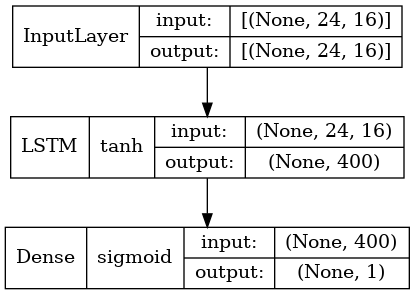

In [12]:
# Load the final model
final_model = tf.keras.saving.load_model('./models/final_models/0028.keras')
tf.keras.utils.plot_model(final_model, show_shapes=True, show_layer_activations=True, show_layer_names=False, to_file='./static/final.png')

### Model Evaluation

To evaluate the model, it is trained on the test data which has been held back. The scaled data is reimported and put through the pairwise correlation and boruta pipeline. The pipeline is converted to a `tensorflow` Dataset using the timeseries utility function, giving the same dataset as used in the experimentations designed above.

In [13]:
# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv',
                      parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv',
                      parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv',
                     parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv',
                     parse_dates=True, index_col='unix')
X_val = pd.read_csv('data/val/scaled_X_val.csv',
                    parse_dates=True, index_col='unix')
y_val = pd.read_csv('data/val/y_val.csv', parse_dates=True, index_col='unix')

# Calculate the weights for the imbalanced classes
y = pd.concat([y_train, y_val, y_test])
weights = cwts(y.values.flatten())

# Define the various feature selection methods
rf = RandomForestClassifier(n_jobs=-1, class_weight=weights)
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, perc=90)
corr = RemoveCorPairwiseTransform()

pipe = Pipeline([('pairwisecorr', corr), ('boruta', boruta)])

X_train_pipe = pipe.fit_transform(X_train, y_train.values.ravel())
X_val_pipe = pipe.transform(X_val)
X_test_pipe = pipe.transform(X_test)

seqlen = 24
featurelen = X_train_pipe.shape[-1]

# Define the tensors
train_tensors = tf.keras.utils.timeseries_dataset_from_array(
    X_train_pipe, y_train.iloc[seqlen-1:], seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(
    X_val_pipe, y_val.iloc[seqlen-1:], seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(
    X_test_pipe, y_test.iloc[seqlen-1:], seqlen)

In [31]:
# Get the list of features that is remaining
correlated_features = pipe['pairwisecorr'].get_removed()
boruta_features = pipe['boruta'].support_
uncorrelated_features = X_train.copy().drop(correlated_features, axis=1)
retained_features = uncorrelated_features.columns[boruta_features]
pd.DataFrame(retained_features, columns=['retained_feature'])

,retained_feature
0,open
1,high
2,ABER_XG_5_15
3,ACCBL_20
4,ACCBU_20
5,ADX_14
6,AGj_13_8_5
7,ALPHAT_14_1_50
8,OBV_min_2
9,OBV_max_2


It is interesting to note when examining the retained features that the fear and greed index data and seasonality data has been dropped. This indicates that these features may need some additional transformations in order to have a significant impact on the model or that they are not as useful in predicting short term movements as other features.

It is also interesting to note that the candlestick patterns are not included either. There goes hundreds of years of Japanese know how! 

The remaining features seem to be a good mix of raw data, momentum indicators and trend. The function names can be found at https://ta-lib.org/functions/ and there is volumes of information on their definition and usage available online.

In [16]:
# Predict the test data
prediction_test = np.where(final_model.predict(test_tensors, verbose=0) > 0.5, 1, 0).flatten()
# Print the classification report
print(classification_report(y_test.iloc[seqlen-1:], prediction_test))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     11169
           1       0.31      0.64      0.42      1475

    accuracy                           0.79     12644
   macro avg       0.63      0.73      0.64     12644
weighted avg       0.87      0.79      0.82     12644



ANALYSE THE CLASSIFICATION REPORT

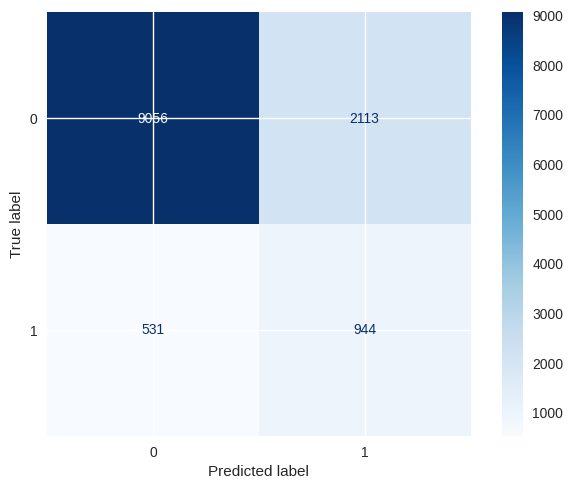

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test.iloc[seqlen-1:], prediction_test, cmap='Blues')
plt.show()

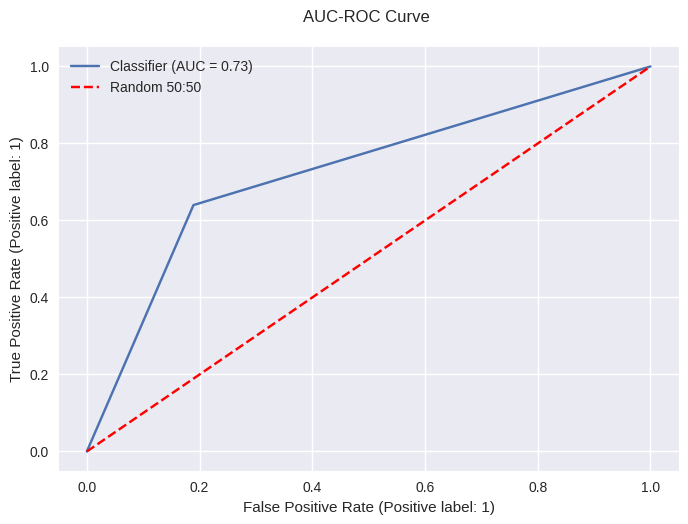

In [18]:
RocCurveDisplay.from_predictions(y_test.iloc[seqlen-1:], prediction_test)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='r')
plt.legend()
plt.show()

### Backtesting

Approaches to backtesting can vary but I have implemented a long only strategy only. This will be conpared to a long hold for the beginning of the period.

A few assumption have been made when considering the strategy:

- That the minimum holding period will be for the duration of the timestep (i.e. 1 hour in this case)
- That a long position can be taken in the security at the close price from the previous step, thus locking in the maximum return
- That the investor operating the strategy can borrow for free or has access to cash to continue taking positions when all funds are lost

These assumptions are not approproate is a real market situation and should be considered further should this strategy need to be used in production.

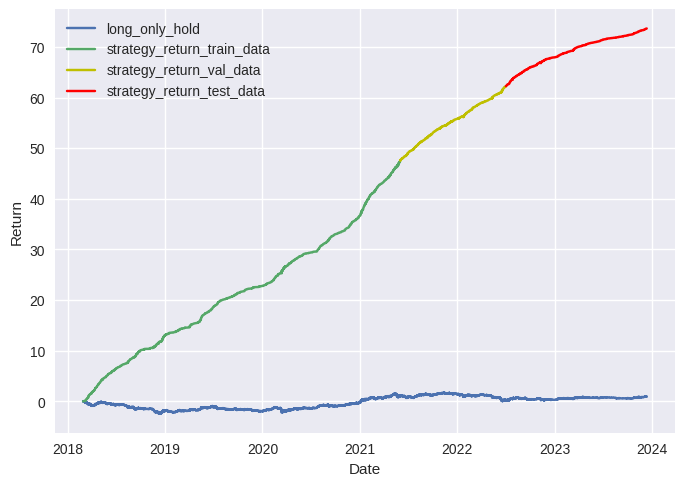

In [26]:
# Prepare all the data
all_processed_features = np.concatenate([X_train_pipe, X_val_pipe,X_test_pipe])
all_y = pd.concat([y_train, y_val, y_test])

# Convert to tensors
all_data_tensors = tf.keras.utils.timeseries_dataset_from_array(all_processed_features, all_y.iloc[seqlen-1:], seqlen)

# Collect all the predictions
predictions = np.where(final_model.predict(all_data_tensors, verbose=0) > 0.5, 1, 0)

# Calculate the start dates for validation and test data sets
val_start = X_val.iloc[0].name
test_start = X_test.iloc[0].name

# Instantiate the strategy class
long_only_strategy = LongOnlyBacktest(df['LOGRET_1'].iloc[seqlen-1:], predictions, val_start, test_start)

# Plot the results
long_only_strategy.plot()

Wow! I'm going to be a billionaire!

But seriously, the backtesting does appear to indicate that the model is very good at generating a consistent return. However, significantly 'in the wild' with real market data and order books would need to be undertaken before using real money to invest. The above indicates that there may be some data leakage in the model that should be investigated further.

Arguably, the reason for the good backtest is that downward movements are predicted very well (0.94 precision) meaning any mistakes are quickly rectified. Combined with how most 

The first 100 results of the strategy can be found in Appendix 5.

### Conclusions

The final model failed to beat the sensible baseline by 1.64%. However, it did do relatively well when real investment actions were simulated (subject to further testing) so the model could warant further analysis and testing, incorporating more real world trading conditions.

It is interesting to note that the fear and greed index ultimately had no impact on the analysis, potentially indicating that there is value in ignoring the noise and sticking to a dispassionate strategy.

Thank you for reading.

### Appendices

##### Appendix 1 - Process Diagram

##### Appendix 2 - Features and Scalers

In [24]:
appendix_2 = pd.read_csv('static/scalers.csv', index_col='scaler')
appendix_2

,feature
scaler,
RobustScaler,ABER_ATR_5_15
MinMaxScaler,ABER_SG_5_15
MinMaxScaler,ABER_XG_5_15
MinMaxScaler,ABER_ZG_5_15
MinMaxScaler,ACCBL_20
MinMaxScaler,ACCBM_20
MinMaxScaler,ACCBU_20
MinMaxScaler,AD
RobustScaler,ADOSC_3_10


##### Appendix 3 - UMAP Parameters

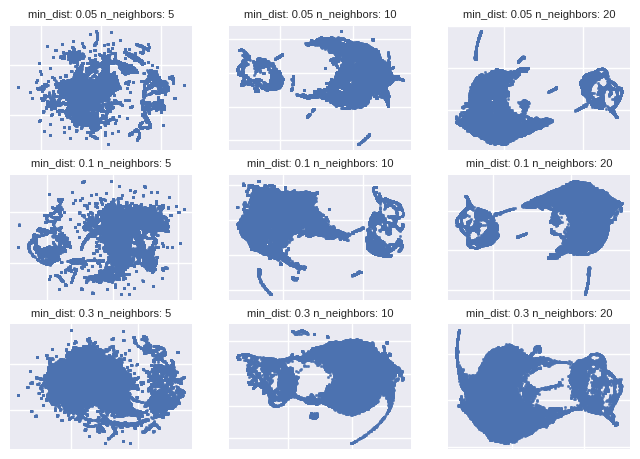

In [25]:
plot_umap(X_train)

##### Appendix 4 - Hypertuning Results

In [32]:
present_tensorboard_logs('model_tuning')

,max_binary_accuracy,max_binary_accuracy_epoch,max_precision,max_precision_epoch,max_recall,max_recall_epoch,max_f1,max_f1_epoch
run_name,,,,,,,,
baseline_24_hour_0028,0.680384,12,0.387734,12,0.863510,4,0.499422,12
baseline_24_hour_0022,0.729239,4,0.419468,4,0.751625,0,0.490235,0
baseline_24_hour_0002,0.656220,1,0.367180,1,0.766945,0,0.483677,1
baseline_24_hour_0012,0.739897,1,0.435823,1,0.592386,0,0.481419,0
baseline_24_hour_0013,0.620977,1,0.349266,1,0.888115,0,0.481225,1
baseline_24_hour_0017,0.634695,5,0.354291,6,0.832869,0,0.480335,6
baseline_24_hour_0027,0.750448,1,0.449738,1,0.805014,10,0.476830,2
baseline_24_hour_0016,0.726918,7,0.419985,7,0.708449,4,0.476242,8
baseline_24_hour_0011,0.601456,0,0.339275,0,0.888115,1,0.475635,0


##### Appendix 5 - Strategy Results

In [28]:
long_only_strategy.results.head(100)

,return,long_only_hold,predictions,holding_begin_period,holding_end_period,strategy_return
unix,,,,,,
2018-02-27 08:00:00+00:00,0.002905,0.002905,0,0.0,0,0.000000
2018-02-27 09:00:00+00:00,-0.002501,0.000404,0,0.0,0,0.000000
2018-02-27 10:00:00+00:00,-0.014487,-0.014083,1,0.0,1,0.000000
2018-02-27 11:00:00+00:00,0.005351,-0.008732,0,1.0,0,0.005351
2018-02-27 12:00:00+00:00,-0.000102,-0.008834,0,0.0,0,0.005351
2018-02-27 13:00:00+00:00,0.007395,-0.001439,0,0.0,0,0.005351
2018-02-27 14:00:00+00:00,-0.010175,-0.011614,0,0.0,0,0.005351
2018-02-27 15:00:00+00:00,-0.011429,-0.023043,0,0.0,0,0.005351
2018-02-27 16:00:00+00:00,0.004129,-0.018913,0,0.0,0,0.005351
